#Deep Learning for QSAR and Cell Identification
_by David Holmberg (February 2023), adapted from materials prepared by Phil Harrison (2021)_

### Artificial neural networks for QSAR

#### Dataset
For this exercise we will use the same dataset of aqueous solubility of 1142 diverse chemical compounds as you previously explored during the QSAR lab last week. However, here we will only use the PhysChem descriptors.

#### Modelling comparisons
1. Compare the results of linear regression to those of a simple neural network with no hidden layers and no non-linear activation functions
2. Compare the results of a simple neural network to those of a deeper neural network with hidden layers and non-linear .

#### Aims
* to see the link between neural networks and linear regression
* to learn the basics of how to define, compile, fit and evaluate neural networks via TensorFlow.

#### Note
We will be using the open-source machine learning framework TensorFlow (https://www.tensorflow.org) and Keras (https://keras.io) for our neural networks. TensorFlow was developed by the Google Brain team and is a widely used machine learning frameworks in research and industry and Keras was the most popular higher-level API that runs atop TensorFlow. Today Keras has been entirely absorbed by Tensorflow, making it signidicantly easier to handle without touching the boilerplate.

## Load packages

In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, datasets
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import random
import cv2
import re
import glob
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from datetime import datetime

from tifffile import imread
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
print(tf.__version__)


2.12.0-rc0


## Plotting functions

In [37]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    ax = fig.add_subplot(122)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

## Load and preprocess data

#### Load and check shape of X and y

In [38]:
X = np.load('data/X_qsar.npy')
y = np.load('data/y_qsar.npy')
print(X.shape)
print(y.shape)

(1126, 8)
(1126,)


#### Split into training and test sets and standardize the data
Here we will just have a training and test set, so our results will not be as rigerous as those you got with cross-validation in the supervised machine learning lab.

In [39]:
n_train = int(len(y) * 0.7) # 70% of data for training and 30% for testing

random.seed(1234)
indices = np.arange(len(y))
random.shuffle(indices)

# X_train0 is our training data prior to standardization
X_train0, X_test0 = X[indices[:n_train]], X[indices[n_train:]]
y_train, y_test = y[indices[:n_train]], y[indices[n_train:]]

# standardize X_train0 and X_test0 to give X_train and X_test
scaler = StandardScaler().fit(X_train0)
X_train = scaler.transform(X_train0)
X_test = scaler.transform(X_test0)

## Linear Regression

In [40]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
LR_mse = mean_squared_error(y_test, LR_pred)
print('Linear Regression: MSE = ' + str(np.round(LR_mse, 3)))

Linear Regression: MSE = 0.938


## Artifical neural network as a linear regression
If we define a neural network with no hidden layers and no non-linear activations we essentailly get the same results as we do with basic linear regression. The results below should help clarify that to you (there are some minor differences hovever, hence the MSE for the neural network will not be _exactly_ the same as the results above for linear regression, but they are neverthelss very close).

<p>
    <img src="figs/lin-reg.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 1. Our neural network version of linear regression.</center>
</p>

#### Define and summarise the model

In [41]:
inps = layers.Input(shape=X_train[0].shape)
preds = layers.Dense(1)(inps)

ANN1 = models.Model(inputs=inps, outputs=preds)
ANN1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit the model
The learning rate and optimizer chosen below are both things that can be changed when one explores hyper parameter options, different architectures and what not. Below we use a learning rate (lr) of 0.001 (a common default learning rate) and the 'RMSprop' optimizer.

In [42]:
lr = 0.001

ANN1.compile(optimizer=optimizers.RMSprop(learning_rate=lr), loss='mse')

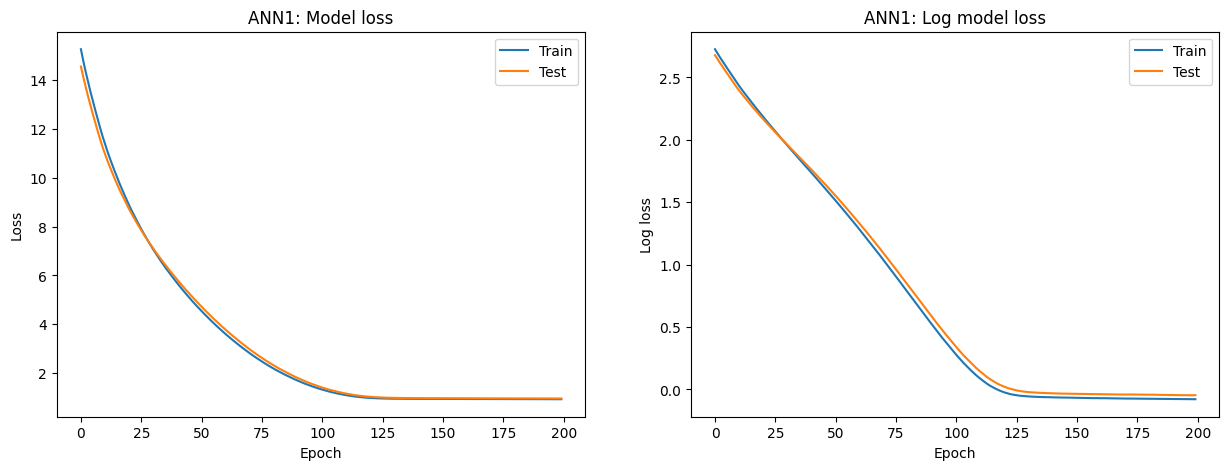

In [43]:
history = ANN1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)
plot_history(history, 'ANN1')

#### Evaluate the model

In [44]:
ANN1_mse = ANN1.evaluate(X_test, y_test, verbose=0)
print('ANN1: MSE = ' + str(np.round(ANN1_mse, 3)))

ANN1: MSE = 0.955


## Going deeper with ANNs 
In the cells below we define, compile, fit and evaluate a neural network model with:
* two hiiden layers, each with 32 neurons and non-linear activations (relu)
* a dropout layer at the end with a dropout rate of 0.2

<p>
    <img src="figs/relu-activation.png" alt="drawing" style="width:500px;"/>
    <center>Figure 2. relu activation.</center>
</p>

Dropout can help to avoid overfitting, much as L1 and L2 regularizations do (as you explored in the supervise machine learning lab). In the model loss plots (below) this stops the test loss from increasing as you train for more epochs.

Some quotes from a paper I co-authored called "Deep Learning in Image Cytometry: A Review" (https://onlinelibrary.wiley.com/doi/full/10.1002/cyto.a.23701):

"_Overfitting occurs when the parameters of a model fit too closely to the input training data, without capturing the underlying distribution, and thus reducing the model’s ability to generalize to other datasets_".

DROPOUT: "_A regularization technique that reduces the interdependent learning among the neurons to prevent overfitting. Some neurons are randomly “dropped,” or disconnected from other neurons, at every training iteration, removing their influence on the optimization of the other neurons. Dropout creates a sparse network composed of several networks—each trained with a subset of the neurons. This transformation into an ensemble of networks hugely decreases the possibility of overfitting, and can lead to better generalization and increased accuracy_".

<p>
    <img src="figs/dropout.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 3. Dropout.</center>
</p>

In what comes below there are no missing cells or code lines for you to fill in, this is simply an example. But pay attention to how the code is written below as in the jupyter notebook 'day1_part2' there will be missing parts that you will have to fill in. The code below will help you with those later tasks.

In [45]:
inps = layers.Input(shape=X_train[0].shape)
x = layers.Dense(32, activation='relu')(inps)
x = layers.Dense(32, activation='relu')(x)
### TODO add another layer to the network here:
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(1)(x)

ANN2 = models.Model(inputs=inps, outputs=preds)
ANN2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_14 (Dense)            (None, 32)                288       
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable p

In [46]:
lr = 0.001

# TODO compile your model
ANN2.compile(optimizer=optimizers.RMSprop(learning_rate=lr), loss='mse')

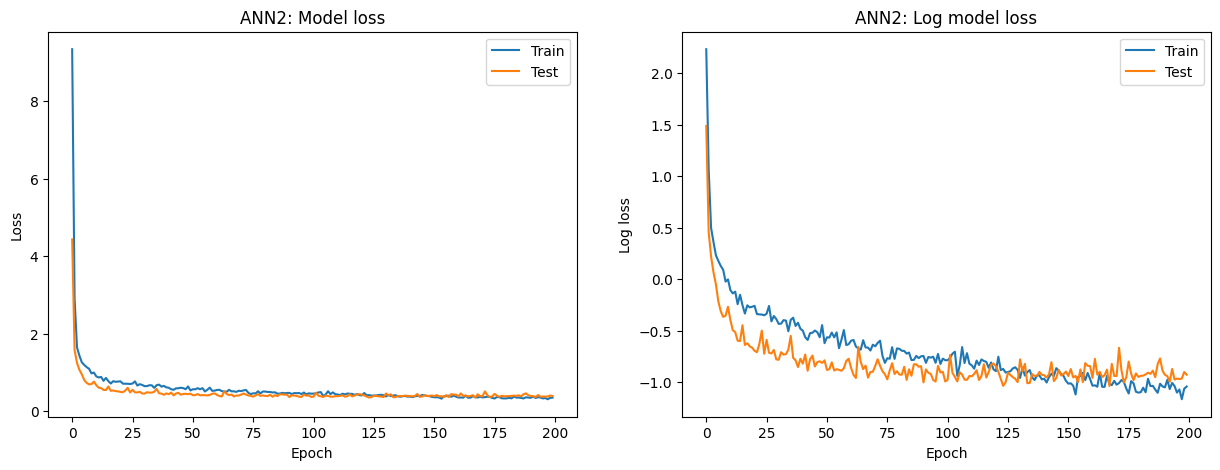

In [47]:
# TODO train your model
history = ANN2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)
plot_history(history, 'ANN2')

In [48]:
ANN2_mse = ANN2.evaluate(X_test, y_test, verbose=0)
print('ANN2: MSE = ' + str(np.round(ANN2_mse, 3)))

ANN2: MSE = 0.396


above you should have gotten the lowest MSE for the neural network, followed by the random forest and then the support vector regressor. These results are however not the final say. Different hyper parameter settings for any of these machine learning algorithms could change the rankings. For neural networks there are many hyper parameters that one could explore, including the network architecture, the number of layers, the number of neurons per layer, the drop out rate(s), the learning rate and the optimizer to use. In later labs this week we will explore these, and additional, choices. A full comparison would also better be done via cross validation as our results above are also affected by the train/test splitting of the data...

### CNN for Image-Based Cell Classification

### Dataset
We will be using a simplified subset of the data analysed in the paper "Deep Convolutional Neural Networks For Detecting Cellular Changes Due To
Malignancy" by Wieslander et al. (2017) (http://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w1/Wieslander_Deep_Convolutional_Neural_ICCV_2017_paper.pdf). The CNNs we'll be training in this exercise will be more basic than those used in that paper.


<p>
    <img src="figs/oral_cancer_summary.png" alt="drawing"  style="width:800px;"/>
    <center>Figure 1. Oral cancer data summary.</center>
</p>

Example cell images Weislander et al. used are shown below. These images were greyscale and 80 x 80 pixels.

<p>
    <img src="figs/cancer_cells.png" alt="drawing" style="width:800px;"/>
    <center>Figure 2. Example oral cancer cell images.</center>
</p>

To simplify the data for the exercise the images have been cropped into 48x48 pixels around the cell. All the images were then shuffled and allocated to the training, validation or test set. Hence, here we are solving a simpler classification task than the more robust one carried out by Weislander et al. where the data were not shuffled and cells from a given patient could only be in one of the three sets. A more robust and generalizable approach would be to do what Weislander et al. did, so keep this in mind.

### Note
Some of the code cells below are boiler plate code, for getting things in the right format, plotting various things and what not. You are encouraged to read and understand what the cells do, it is not required to complete the exercise. Other cells contain either minimal or partial code that you will need to implement. Regardless you need to run all cells below for the notebook to function.

Also below we use `generators` to load the data from directories in small batches. This is useful if your dataset is bigger than fits into the GPU Memory (VRAM). GPUs are super fast for fitting neural networks, much faster than CPUs, but have limited VRAM, and limited access to system RAM. There are other ways of handling data loading, which will be useful should you decide to use deep-learning in the future.

In [49]:
#Plotting and Summarizing functions
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(20,6), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Training', 'Validation'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy', 
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, classes, model_name,
                          cmap=plt.cm.Blues):
    title = model_name
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_sample_images():
    # plot 5 healthy cells form training data
    print('random sample of healthy cells from training set')
    print('')
    all_cells = glob.glob(train_healthy_dir + '/' '*')
    n_cells = len(all_cells)
    to_plot = np.random.choice(n_cells, 5, replace=False)

    plt.figure(figsize=(20, 120), facecolor='w')

    for i in range(5):
        im = imread(all_cells[to_plot[i]])
        sub_index = 151 + i
        plt.subplot(sub_index)
        plt.imshow(im[:, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])


    plt.show()
    plt.close()

    # plot 5 tumor cells form training data
    print('')
    print('random sample of tumor cells from training set')
    print('')
    all_cells = glob.glob(train_tumor_dir + '/' '*')
    n_cells = len(all_cells)
    to_plot = np.random.choice(n_cells, 5, replace=False)

    plt.figure(figsize=(20, 120), facecolor='w')

    for i in range(5):
        im = imread(all_cells[to_plot[i]])
        sub_index = 151 + i
        plt.subplot(sub_index)
        plt.imshow(im[:, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])


    plt.show()
    plt.close()

def data_summary():
    print('no. training healthy images:', len(os.listdir(train_healthy_dir)))
    print('no. training tumor images:', len(os.listdir(train_tumor_dir)))
    print('')
    print('no. validation healthy images:', len(os.listdir(validation_healthy_dir)))
    print('no. validation tumor images:', len(os.listdir(validation_tumor_dir)))
    print('')
    print('no. test healthy images:', len(os.listdir(test_healthy_dir)))
    print('no. test tumor images:', len(os.listdir(test_tumor_dir)))

In [50]:
# directory we will store our dataset
base_dir = 'HPV/data_v3'

# directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# directory with our training healthy cell images
train_healthy_dir = os.path.join(train_dir, 'healthy')

# directory with our training tumor cell images
train_tumor_dir = os.path.join(train_dir, 'tumor')

# directory with our validation healthy cell images
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# directory with our validation tumor cell images
validation_tumor_dir = os.path.join(validation_dir, 'tumor')

# directory with our test healthy cell images
test_healthy_dir = os.path.join(test_dir, 'healthy')

# directory with our test tumor cell images
test_tumor_dir = os.path.join(test_dir, 'tumor')

In [51]:
data_summary()

no. training healthy images: 1281
no. training tumor images: 784

no. validation healthy images: 316
no. validation tumor images: 198

no. test healthy images: 401
no. test tumor images: 243


random sample of healthy cells from training set



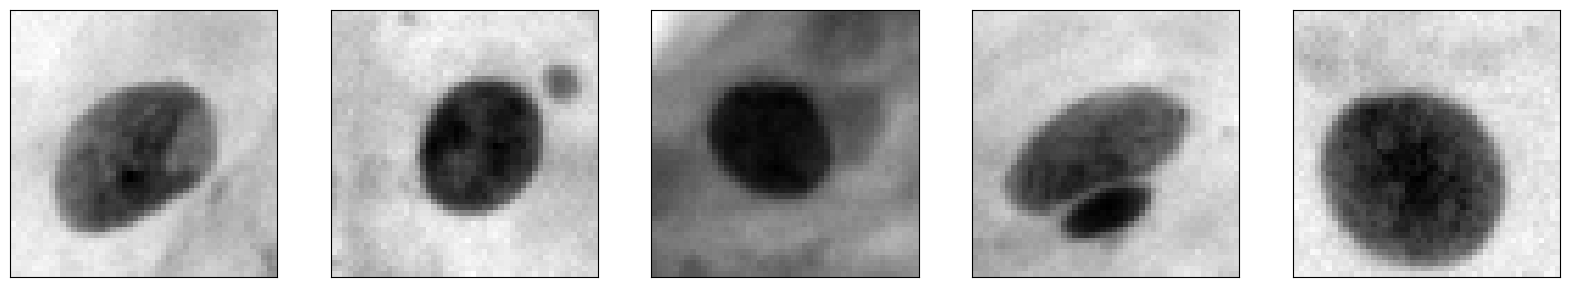


random sample of tumor cells from training set



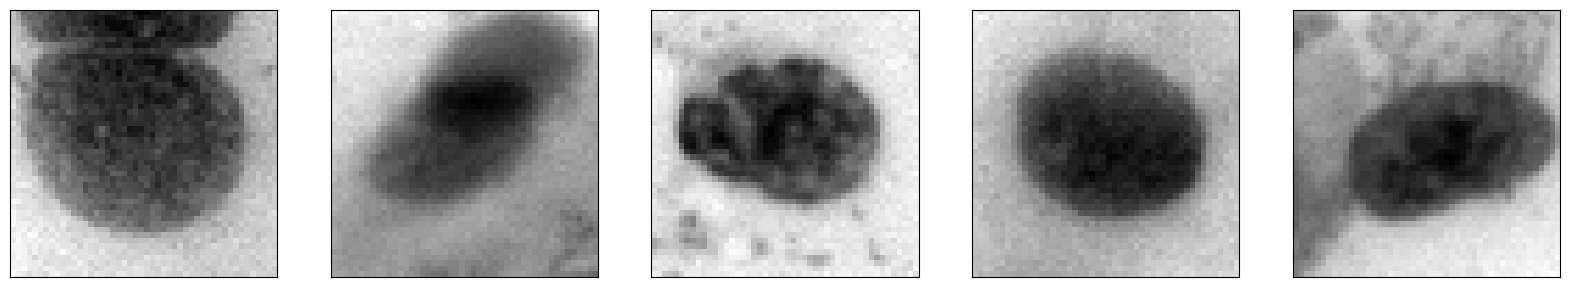

In [52]:
plot_sample_images()

In [53]:
x_len = 48
y_len = 48
batch_size = 32
n_epochs = 50

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print('TRAINING DATA:')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

print('')
print('VALIDATION DATA:')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False)

print('')
print('TEST DATA:')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False)

train_steps = (len(os.listdir(train_healthy_dir)) + len(os.listdir(train_tumor_dir))) // batch_size
validation_steps = (len(os.listdir(validation_healthy_dir)) + len(os.listdir(validation_tumor_dir))) // batch_size
test_steps = (len(os.listdir(test_healthy_dir)) + len(os.listdir(test_tumor_dir))) // batch_size
    
def valid_evaluate(model):
    y_pred = model.predict(validation_generator, validation_steps+1)
    y_pred = y_pred > 0.5
    y_true = validation_generator.classes
    class_names = ['healthy', 'tumor']
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name='confusion matrix for validation data')
    plt.show()
    plt.close()
    
    print('')
    print('classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3))

def test_evaluate(model):
    y_pred = model.predict(test_generator, test_steps+1)
    y_pred = y_pred > 0.5
    y_true = test_generator.classes
    class_names = ['healthy', 'tumor']
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name='confusion matrix for test data')
    plt.show()
    plt.close()
    
    print('')
    print('classification report for test data:')
    print(classification_report(y_true, y_pred, digits=3))

TRAINING DATA:
Found 2065 images belonging to 2 classes.

VALIDATION DATA:
Found 514 images belonging to 2 classes.

TEST DATA:
Found 644 images belonging to 2 classes.


#### Basic convolutional neural network (CNN)

Convolutional Neural Networks (CNNs) use convolutions instead of the normal fully connected layers, which have proven to be highly successful for 2D-data tasks. By convolving filters on the input layer and outputting the results to the next layer, the CNN "detects" (or learns) features at different levels of abstraction throughout the network. With lower-level abstractions (like edges and blobs) in the early layers, and higher-level abstractions (like cells) in deeper layers. The figure below shows the LeNet inspired CNN that we will shortly be implementing.

<p>
    <img src="figs/CNN.png" alt="drawing" style="width:1200px;"/>
</p>

#### Example CNN
The following cells briefly show how to define, compile, and train a model:

In [54]:
in_data = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(in_data)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation='sigmoid')(x)

CNN_1 = models.Model(inputs=in_data, outputs=out)
CNN_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0   

In [55]:
CNN_1.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

Epoch 1/50
64/64 - 3s - loss: 0.6695 - accuracy: 0.6188 - val_loss: 0.6498 - val_accuracy: 0.6172 - 3s/epoch - 42ms/step
Epoch 2/50
64/64 - 1s - loss: 0.6210 - accuracy: 0.6434 - val_loss: 0.5843 - val_accuracy: 0.7520 - 1s/epoch - 23ms/step
Epoch 3/50
64/64 - 1s - loss: 0.5640 - accuracy: 0.7314 - val_loss: 0.5903 - val_accuracy: 0.6855 - 1s/epoch - 20ms/step
Epoch 4/50
64/64 - 1s - loss: 0.5451 - accuracy: 0.7329 - val_loss: 0.5449 - val_accuracy: 0.7520 - 1s/epoch - 18ms/step
Epoch 5/50
64/64 - 2s - loss: 0.5497 - accuracy: 0.7304 - val_loss: 0.5484 - val_accuracy: 0.7441 - 2s/epoch - 24ms/step
Epoch 6/50
64/64 - 1s - loss: 0.5238 - accuracy: 0.7432 - val_loss: 0.5337 - val_accuracy: 0.7500 - 1s/epoch - 18ms/step
Epoch 7/50
64/64 - 1s - loss: 0.5107 - accuracy: 0.7659 - val_loss: 0.5318 - val_accuracy: 0.7500 - 1s/epoch - 19ms/step
Epoch 8/50
64/64 - 1s - loss: 0.5148 - accuracy: 0.7526 - val_loss: 0.5205 - val_accuracy: 0.7676 - 1s/epoch - 19ms/step
Epoch 9/50
64/64 - 1s - loss: 0.

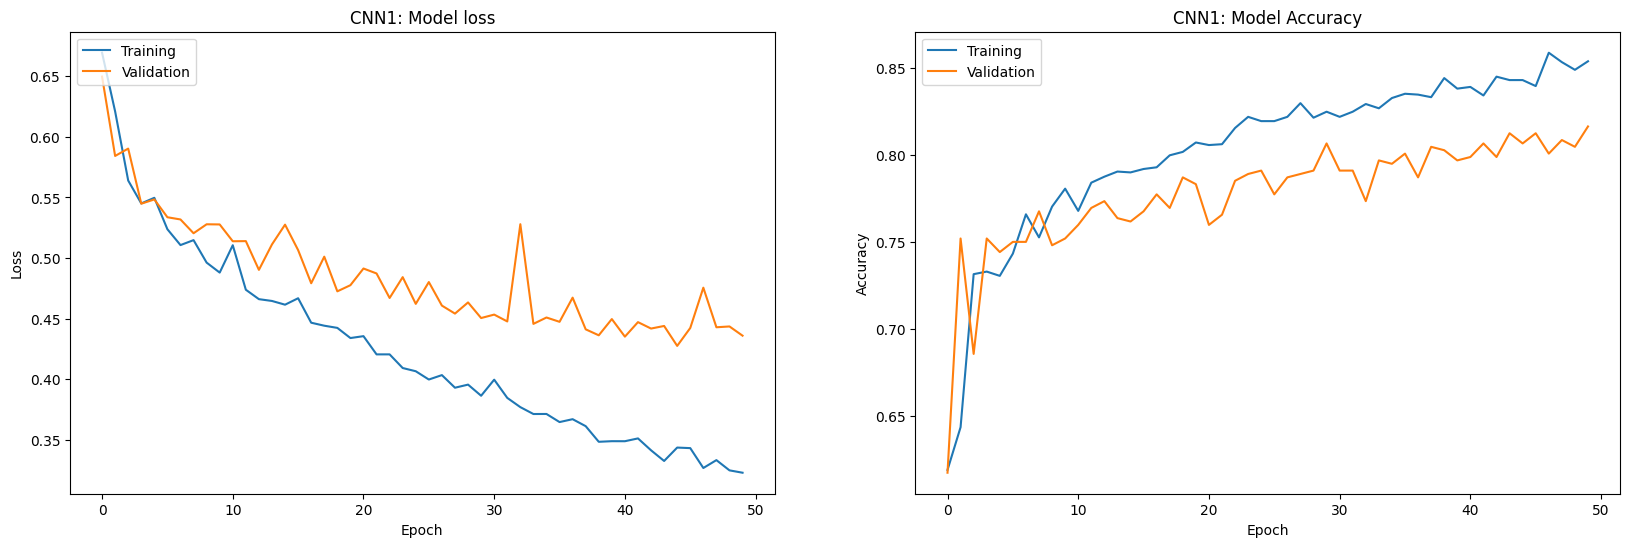

17/17 [==============================] - 0s 15ms/step


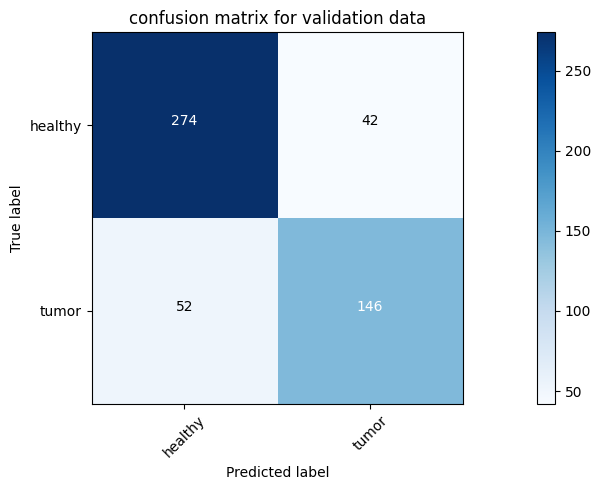


classification report for validation data:
              precision    recall  f1-score   support

           0      0.840     0.867     0.854       316
           1      0.777     0.737     0.756       198

    accuracy                          0.817       514
   macro avg      0.809     0.802     0.805       514
weighted avg      0.816     0.817     0.816       514



In [56]:
history = CNN_1.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN1')

valid_evaluate(CNN_1)

## your own architectures
In the code cells below try some alternative model architectures. Use the 'weighted avg f1-score' on the validation data to compare different model architectures and to decide which one was best.

* try fitting two different models with different numbers of convolutional layers (you can have between two and five for this data, more than five convolutional layers does not work for this data due to the shrinking of the spatial dimensions of the filter maps as they go through max pooling)
* you can also play around with the number of filters for each convolutional layer
* and you can experiment with different values for the dropout rate, or with no dropout at all (by either setting the dropout rate to 0.0 or removing the dropout code line all together)
* finally, you are free to explore different numbers of neurons for the final dense layer (just before our prediction (preds) layer).

#### Notes: 
* if your model does not seem to have converged after 25 epochs (the default value) you can also raise the number of epochs to train for.
* name your model CNN2, CNN3 etc.

In [57]:
# TODO Define you own CNN here
input = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

CNN_2 = models.Model(inputs=input, outputs=output)
CNN_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 64)        1849

In [58]:
# TODO Compile your CNN here
CNN_2.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])


Epoch 1/50
64/64 - 3s - loss: 0.6569 - accuracy: 0.6208 - val_loss: 0.6152 - val_accuracy: 0.6914 - 3s/epoch - 45ms/step
Epoch 2/50
64/64 - 1s - loss: 0.5498 - accuracy: 0.7319 - val_loss: 0.5620 - val_accuracy: 0.7500 - 1s/epoch - 18ms/step
Epoch 3/50
64/64 - 1s - loss: 0.5249 - accuracy: 0.7624 - val_loss: 0.5324 - val_accuracy: 0.7441 - 1s/epoch - 19ms/step
Epoch 4/50
64/64 - 1s - loss: 0.5205 - accuracy: 0.7550 - val_loss: 0.5196 - val_accuracy: 0.7793 - 1s/epoch - 20ms/step
Epoch 5/50
64/64 - 1s - loss: 0.5091 - accuracy: 0.7659 - val_loss: 0.5337 - val_accuracy: 0.7676 - 1s/epoch - 23ms/step
Epoch 6/50
64/64 - 1s - loss: 0.5296 - accuracy: 0.7491 - val_loss: 0.5145 - val_accuracy: 0.7520 - 1s/epoch - 20ms/step
Epoch 7/50
64/64 - 1s - loss: 0.4987 - accuracy: 0.7654 - val_loss: 0.5133 - val_accuracy: 0.7559 - 1s/epoch - 19ms/step
Epoch 8/50
64/64 - 1s - loss: 0.4850 - accuracy: 0.7742 - val_loss: 0.5136 - val_accuracy: 0.7441 - 1s/epoch - 19ms/step
Epoch 9/50
64/64 - 1s - loss: 0.

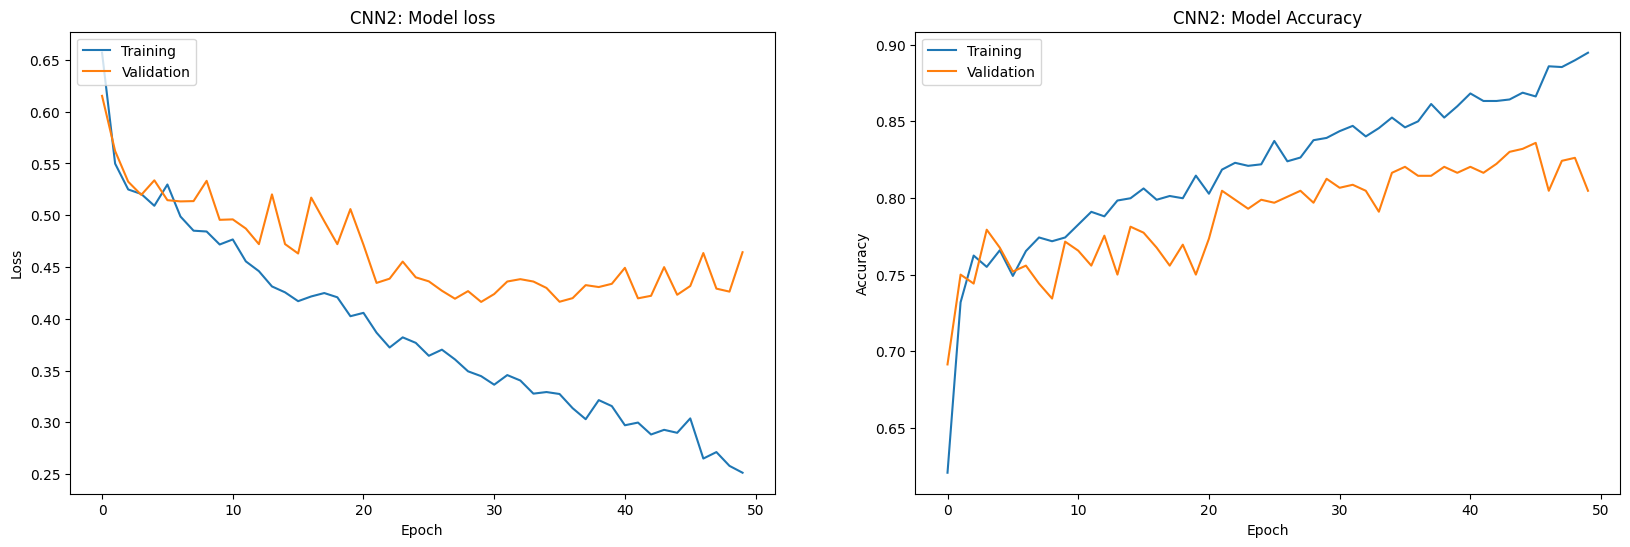

17/17 [==============================] - 0s 15ms/step


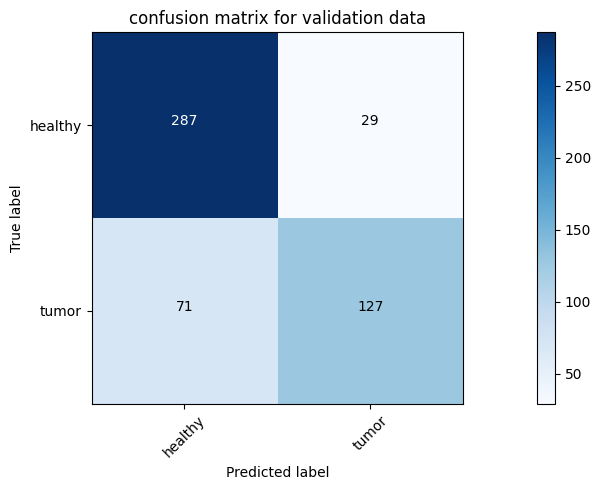


classification report for validation data:
              precision    recall  f1-score   support

           0      0.802     0.908     0.852       316
           1      0.814     0.641     0.718       198

    accuracy                          0.805       514
   macro avg      0.808     0.775     0.785       514
weighted avg      0.806     0.805     0.800       514



In [59]:
# TODO Train and Evaluate your CNN here

history = CNN_2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN2')

valid_evaluate(CNN_2)

#### Adding data augmentation

Data augmentation is a way to try improving the performance of a model by artificially inflating the amount of annotated training data. A common approach of doing this is by either mirroring or rotating the data. 

We will use the same 8x data augmentation as used by Wieslander et al.:

<p>
    <img src="figs/augmentation.png" alt="drawing" style="width:1000px;"/>
</p>

In [60]:
# we add the data augmentations above via training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

Found 2065 images belonging to 2 classes.


In [61]:
# TODO Copy your CNN here and rename it to something else. for example, CNN_aug
input = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

CNN_aug = models.Model(inputs=input, outputs=output)
CNN_aug.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 64)        184

In [62]:
# TODO Compile your new model
CNN_aug.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

Epoch 1/50
64/64 - 3s - loss: 0.6597 - accuracy: 0.6114 - val_loss: 0.6143 - val_accuracy: 0.6172 - 3s/epoch - 48ms/step
Epoch 2/50
64/64 - 2s - loss: 0.5786 - accuracy: 0.7019 - val_loss: 0.6195 - val_accuracy: 0.6387 - 2s/epoch - 25ms/step
Epoch 3/50
64/64 - 2s - loss: 0.5528 - accuracy: 0.7378 - val_loss: 0.5362 - val_accuracy: 0.7480 - 2s/epoch - 27ms/step
Epoch 4/50
64/64 - 2s - loss: 0.5272 - accuracy: 0.7467 - val_loss: 0.5249 - val_accuracy: 0.7578 - 2s/epoch - 29ms/step
Epoch 5/50
64/64 - 2s - loss: 0.5104 - accuracy: 0.7609 - val_loss: 0.5213 - val_accuracy: 0.7559 - 2s/epoch - 31ms/step
Epoch 6/50
64/64 - 1s - loss: 0.5050 - accuracy: 0.7668 - val_loss: 0.5063 - val_accuracy: 0.7695 - 1s/epoch - 23ms/step
Epoch 7/50
64/64 - 2s - loss: 0.5163 - accuracy: 0.7580 - val_loss: 0.6440 - val_accuracy: 0.6348 - 2s/epoch - 26ms/step
Epoch 8/50
64/64 - 2s - loss: 0.5325 - accuracy: 0.7472 - val_loss: 0.5322 - val_accuracy: 0.7695 - 2s/epoch - 25ms/step
Epoch 9/50
64/64 - 2s - loss: 0.

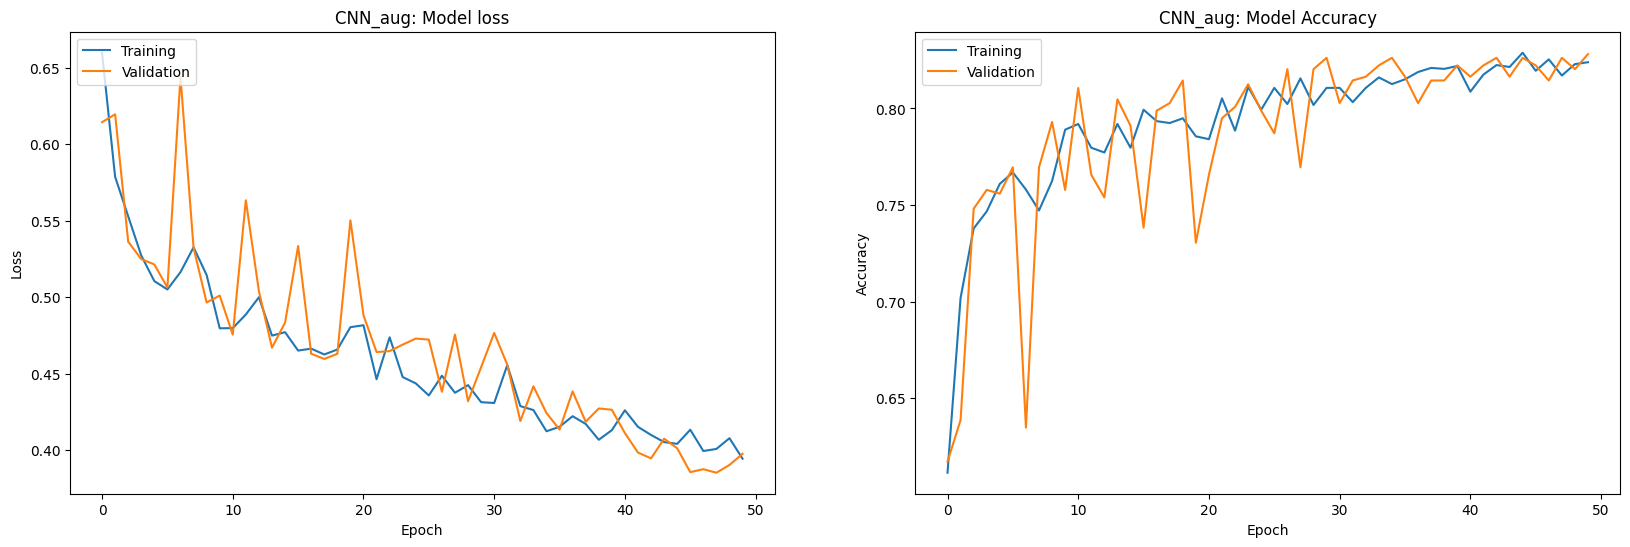

17/17 [==============================] - 0s 14ms/step


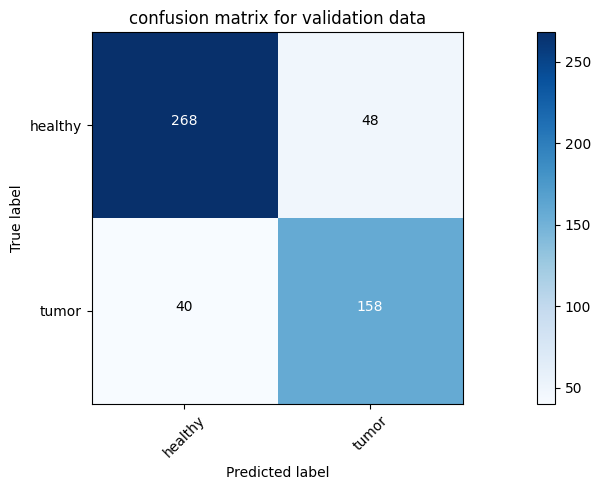


classification report for validation data:
              precision    recall  f1-score   support

           0      0.870     0.848     0.859       316
           1      0.767     0.798     0.782       198

    accuracy                          0.829       514
   macro avg      0.819     0.823     0.821       514
weighted avg      0.830     0.829     0.829       514



In [63]:
# TODO Train you new model
history = CNN_aug.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN_aug')

valid_evaluate(CNN_aug)

#### Regularization
Besides using dropout we can also explore L1 and/or L2 regularization. To add regularization to you model you add ```kernel_regularizer=l2(0.0001)``` to your layer definitions.
i.e you turn

```x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)```

into 

```x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)```

In [64]:
# TODO define your new model, name it something new. I.e CNN_L2. You are free to name it something else, including CNN_L1 if you feel like using l1 regularisation instead:
input = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

CNN_l2 = models.Model(inputs=input, outputs=output)
CNN_l2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 12, 12, 64)        184

In [65]:
# TODO Compile your model
CNN_l2.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

Epoch 1/50
64/64 - 3s - loss: 0.6751 - accuracy: 0.6178 - val_loss: 0.6655 - val_accuracy: 0.6172 - 3s/epoch - 53ms/step
Epoch 2/50
64/64 - 2s - loss: 0.6240 - accuracy: 0.6493 - val_loss: 0.5892 - val_accuracy: 0.7227 - 2s/epoch - 26ms/step
Epoch 3/50
64/64 - 1s - loss: 0.5773 - accuracy: 0.7201 - val_loss: 0.5699 - val_accuracy: 0.7324 - 1s/epoch - 23ms/step
Epoch 4/50
64/64 - 2s - loss: 0.5499 - accuracy: 0.7447 - val_loss: 0.5400 - val_accuracy: 0.7480 - 2s/epoch - 28ms/step
Epoch 5/50
64/64 - 2s - loss: 0.5358 - accuracy: 0.7452 - val_loss: 0.5527 - val_accuracy: 0.7285 - 2s/epoch - 24ms/step
Epoch 6/50
64/64 - 2s - loss: 0.5387 - accuracy: 0.7565 - val_loss: 0.5271 - val_accuracy: 0.7676 - 2s/epoch - 25ms/step
Epoch 7/50
64/64 - 2s - loss: 0.5257 - accuracy: 0.7614 - val_loss: 0.5168 - val_accuracy: 0.7773 - 2s/epoch - 28ms/step
Epoch 8/50
64/64 - 2s - loss: 0.5130 - accuracy: 0.7673 - val_loss: 0.5026 - val_accuracy: 0.7852 - 2s/epoch - 24ms/step
Epoch 9/50
64/64 - 2s - loss: 0.

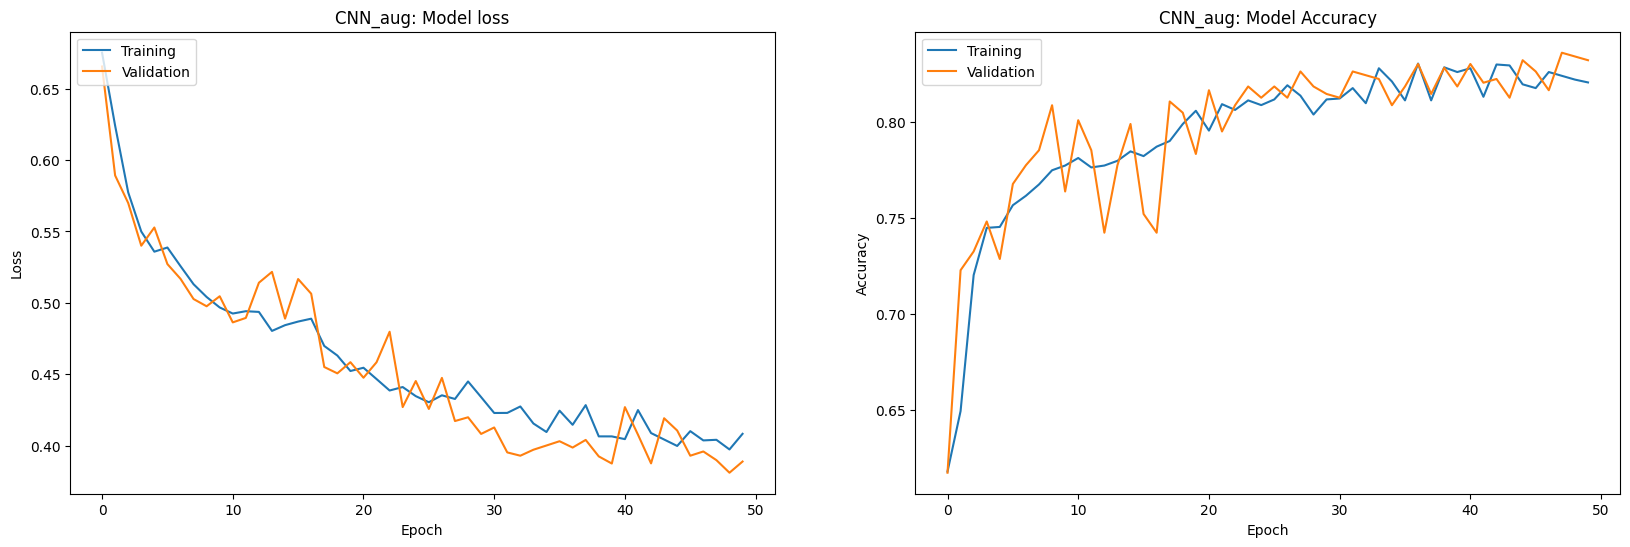

17/17 [==============================] - 0s 18ms/step


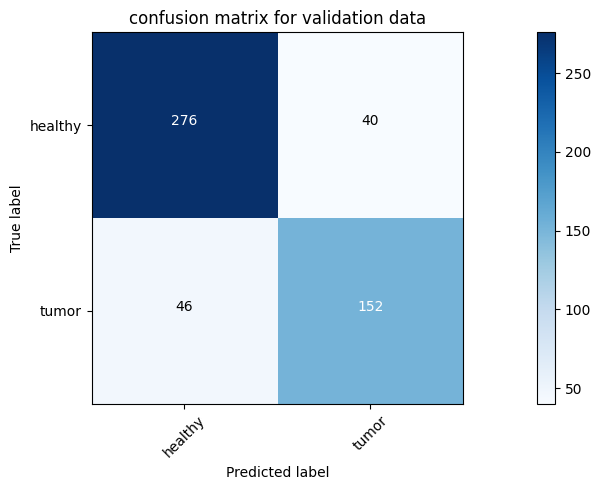


classification report for validation data:
              precision    recall  f1-score   support

           0      0.857     0.873     0.865       316
           1      0.792     0.768     0.779       198

    accuracy                          0.833       514
   macro avg      0.824     0.821     0.822       514
weighted avg      0.832     0.833     0.832       514



In [66]:
# TODO Train your model
history = CNN_l2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN_aug')

valid_evaluate(CNN_l2)

#### Final Evaluation of the models

You should now evaluate the innitial example model and the three models you've defined. The code for evaluating has been provided, and you only need to call on it using the correct funtion name and function inputs.

21/21 [==============================] - 0s 12ms/step


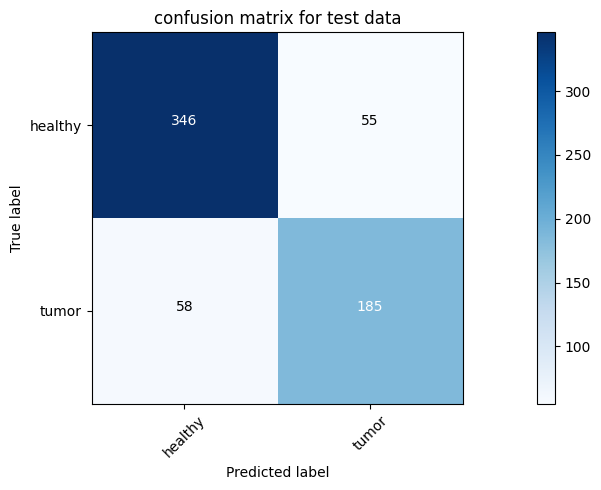


classification report for test data:
              precision    recall  f1-score   support

           0      0.856     0.863     0.860       401
           1      0.771     0.761     0.766       243

    accuracy                          0.825       644
   macro avg      0.814     0.812     0.813       644
weighted avg      0.824     0.825     0.824       644



In [67]:
#Here you will use the provided code to evaluate the innitial model>
test_evaluate(CNN_1)


21/21 [==============================] - 0s 15ms/step


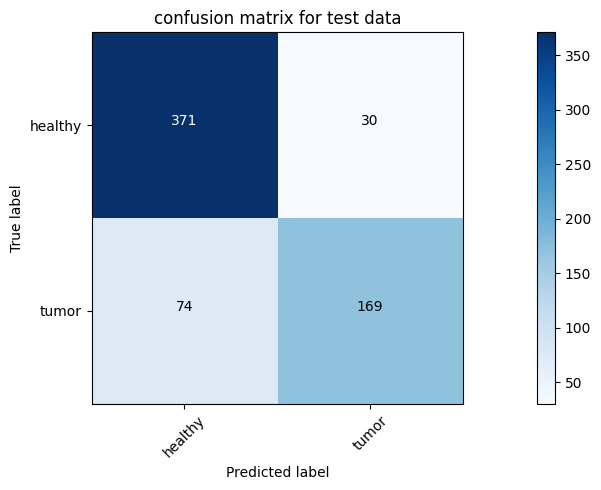


classification report for test data:
              precision    recall  f1-score   support

           0      0.834     0.925     0.877       401
           1      0.849     0.695     0.765       243

    accuracy                          0.839       644
   macro avg      0.841     0.810     0.821       644
weighted avg      0.840     0.839     0.835       644



In [68]:
#Evaluate your own model
test_evaluate(CNN_2)

21/21 [==============================] - 0s 15ms/step


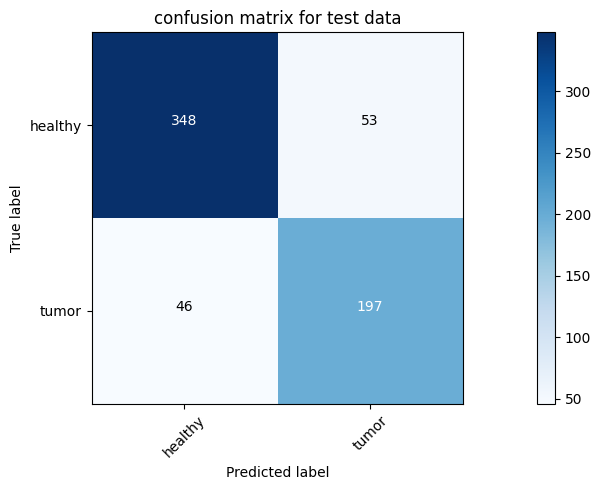


classification report for test data:
              precision    recall  f1-score   support

           0      0.883     0.868     0.875       401
           1      0.788     0.811     0.799       243

    accuracy                          0.846       644
   macro avg      0.836     0.839     0.837       644
weighted avg      0.847     0.846     0.847       644



In [69]:
#Evaluate your own model with augmentation
test_evaluate(CNN_aug)

21/21 [==============================] - 0s 14ms/step


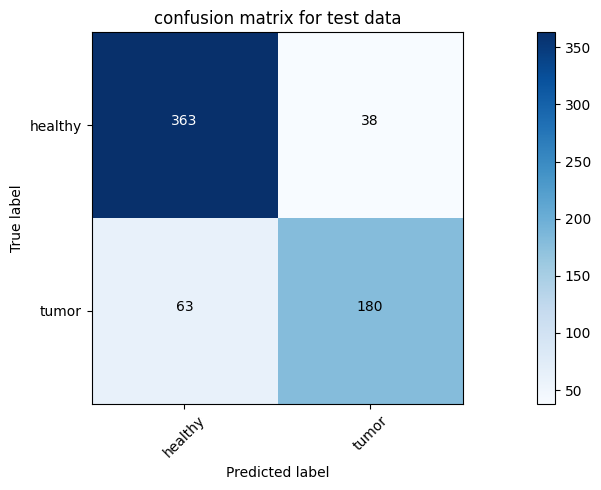


classification report for test data:
              precision    recall  f1-score   support

           0      0.852     0.905     0.878       401
           1      0.826     0.741     0.781       243

    accuracy                          0.843       644
   macro avg      0.839     0.823     0.829       644
weighted avg      0.842     0.843     0.841       644



In [70]:
#Evaluate your own model with regularization
test_evaluate(CNN_l2)

#### Final Notes

You've now finished the lab. Due to the stochastic nature of how Deep Learning works, you have likely all gotten different results. This is expected.